# Practical Session 9: Introduction to deep learning
Aims:
- To introduce the concepts of neural networks, back propagation and the training and test loops

Context:<br>
We will be following section some aspects of Section 5.2 in Stevens and Antiga

In [15]:
!pip install torch pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev





Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --apt-packages


In [12]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits

import torch

## Calibrating an analogue thermometer
### The problem
We just got back from a trip to some obscure location, and we brought back a fancy, wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough, and finally be able to interpret the new readings in units we understand.

We’ll start by making a note of temperature data in good old Celsius5 and measurements from our new thermometer, and figure things out.

RuntimeError: Numpy is not available

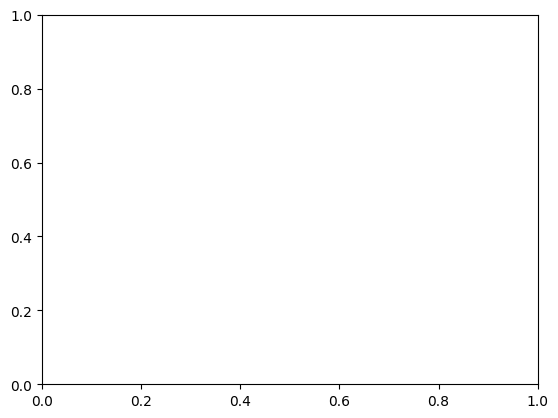

In [13]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

fig, ax = plt.subplots()
ax.scatter(t_u,t_c);
ax.set_xlabel("measurement")
ax.set_ylabel("temperature (Celsius)");


Here, the t_c values are temperatures in Celsius, and the t_u values are our unknown units. We can expect noise in both measurements, coming from the devices themselves and from our approximate readings. For convenience, we’ve already put the data into tensors; we’ll use it in a minute.

### Setting up the fitting manually
In the absence of further knowledge, we will assume a linear model to fit the data and we will assume a squared error loss function (this is the example of linear regression!)

In [ ]:
def model(t_u, w, b):
    return w*t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

# Assume some default values
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
print(t_p)
loss = loss_fn(t_p, t_c)
print(loss)

We need to change the parameters to reduce the loss function and we can do this with **gradient descent**. The gradient of the loss function with respect to the parameters tells us if we need to increase the parameter estimate by a small increment (+ve gradient) or decrease the parameter by a small increment (-ve gradient). In this case we can actually derive the gradient function analytically easily and code it up. The code below calculates the gradient of the loss function and illustrates the training loop where we fit the parameters. The parameter updates are scaled along the gradient by the **learning rate**.

In [ ]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2* (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

# This is the full gradient function
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

# The learning rate is how much to move along the gradient
def training_loop(n_epochs, learning_rate, params, t_u, t_c, pout=10):
    for epoch in range(1, n_epochs + 1):
        w, b = params
 
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
 
        params = params - learning_rate * grad
 
        # Print values at first epoch and then every 10 epochs
        if epoch == 1 or epoch%pout == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            print('\tparams:', params)
            print('\tgrad:', grad)
 
    return params

# Run the training loop
training_loop(n_epochs = 100, learning_rate = 1e-4, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)


We can see the gradients decreasing and the behaviour is stable (ie the parameters appear to be converging). Try increasing the learning rate to 1e-2! See what happens.

There is another problem, if you look at the gradients for the two parameters you can see that they have very different scales. This is a problem since we scale the steps in terms of the same learning rate. We can solve this by scaling the data (approximately for illustrative purposes). This also allows us to increase the learning rate.

In [ ]:
t_un = 0.1 *t_u
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)

OK let's run over 5000 epochs to fit the model and visualise the fit

In [ ]:
params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c, pout=1000)

# this uses unpacking and is equivalent model(t_un, params[0], params[1])
t_p = model(t_un, *params)
 
fig, ax = plt.subplots()
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o');

Our linear model is a good model for the data, it seems. It also seems our measurements are somewhat erratic with large error. We should either call our optometrist for a new pair of glasses or think about returning our fancy thermometer!

### Setting up the fitting using `autograd`
Rather than calculating the gradients by hand we can do this automatically. Here is the updated code:

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:               
            params.grad.zero_()
 
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
 
        with torch.no_grad():                     
            params -= learning_rate * params.grad
 
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
 
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
training_loop(n_epochs = 5000, learning_rate = 1e-2, params = params, t_u = t_un, t_c = t_c)

There are a number of things to understand:
1) We tell PyTorch that we want the parameter tensor to calculate (or hold) the gradient information.
2) Inside the loop we zero the gradient information in each epoch.
3) We call the `backward` method on the loss function which automatically calculates the gradients of the loss function wrt the param tensor
4) In the parameter update step we do not want to change the gradients so we use the `no_grad()` context

### Using inbuilt optimisers
In practice we would not implement the updating of the parameters by hand but use an inbuilt optimiser. In the code below, we modify the training loop to use a stochastic gradient descent optimiser and call the `step` method. 

In [ ]:
import torch.optim as optim

def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

# In[10]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs = 5000, optimizer = optimizer, params = params, t_u = t_un, t_c = t_c)

### Doing the training and testing together 
We need to create a test and training set. In deep learning we rarely do cross-validation due to the computation required for large models. Below we do a single test-train split (and we could use scikit-learn)

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples) # this gives a test set of 20%
 
shuffled_indices = torch.randperm(n_samples)
 
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
print(train_indices, val_indices)

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
 
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
 
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u


The standard approach is to calculate the loss on the train and test datasets as a function of the epoch. The following code does this:

In [ ]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)     
        train_loss = loss_fn(train_t_p, train_t_c)
 
        # this ensures that autodiff is not called when evaluating the test performance
        with torch.no_grad():   
            val_t_p = model(val_t_u, *params)           
            val_loss = loss_fn(val_t_p, val_t_c)
 
        optimizer.zero_grad()
        train_loss.backward()                     
        optimizer.step()
 
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
 
    return params

# In[15]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
 
training_loop(n_epochs = 5000, optimizer = optimizer, params = params,
        train_t_u = train_t_un, val_t_u = val_t_un, train_t_c = train_t_c, val_t_c = val_t_c)
 

### Modelling tasks (1)
Redefine the model to be a quadratic ie w2 * t_u ** 2 + w1 * t_u + b.

1. What parts of the training loop, and so on, need to change to accommodate this redefinition?

2. What parts are agnostic to swapping out the model?

3. Is the resulting loss higher or lower after training?

4. Is the actual result better or worse?

## Using a neural network to fit the data
So far, we’ve taken a close look at how a linear model can learn and how to make that happen in PyTorch. We’ve focused on a very simple regression problem that used a linear model with only one input and one output. Such a simple example allowed us to dissect the mechanics of a model that learns, without getting overly distracted by the implementation of the model itself. 

### Using the neural network module `nn`
For a full introduction to the neural network module you can refer to section 6.2 of Stevens and Antiga. You can also look at the PyTorch documentation that gives a list of all the different layers that are implmented: https://pytorch.org/docs/stable/nn.html. Here I just want to give you a sense of how it is used. 

To recreate our temperature calibration example, we can define a linear neural network with one input feature and one output feature using `nn.Linear(1,1)`. We can also use the `MSELoss` function defined in the module.

In [ ]:
import torch.nn as nn

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)                 
        loss_train = loss_fn(t_p_train, t_c_train)

        with torch.no_grad():  
            t_p_val = model(t_u_val)                    
            loss_val = loss_fn(t_p_val, t_c_val)
 
        optimizer.zero_grad()
        loss_train.backward()                       
        optimizer.step()
 
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
            
            
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

# Need to convert the data into batches as this is how the nn module expects data.
# Splitting data up into batches is very common.
# Here we reshape our B samples into a tensor of B x Nin where Nin = 1, ie each data point is a batch of 1
t_un_train = train_t_un.unsqueeze(1)      
t_un_val = val_t_un.unsqueeze(1)      
t_c_train = train_t_c.unsqueeze(1)      
t_c_val = val_t_c.unsqueeze(1)  
                    
print( t_un_train.shape )
print( t_c_train.shape )
    
training_loop( n_epochs = 5000, optimizer = optimizer, model = linear_model, loss_fn = nn.MSELoss(), 
              t_u_train = t_un_train, t_u_val = t_un_val, t_c_train = t_c_train, t_c_val = t_c_val)
 
print()
print(linear_model.weight)
print(linear_model.bias)

### Fitting a neural network
Now we are already using the `nn` module defining a new network is simple. We stack layers on top of each other using `nn.Sequential` to acheive the following network:
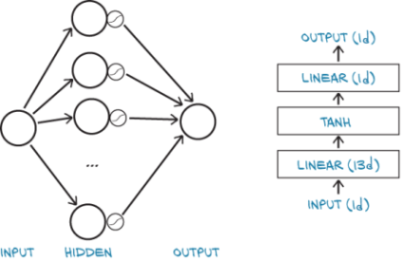

In [ ]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), 
            nn.Tanh(),
            nn.Linear(13, 1))
print(seq_model)

It is useful to extract the parameters of the network so that we cna see how they are stored: weights, bias for the connections to the first layer then weights and bias for the connections to the output layer.

In [ ]:
[param.shape for param in seq_model.parameters()]

We can now run our code on the new model

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
 
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)
 
print('output', seq_model(t_un_val))
print('answer', t_c_val)

### Visualising the fit
Let's visualise the resultant fit. We can appreciate that the neural network has a tendency to overfit, as we discussed in chapter 5, since it tries to chase the measurements, including the noisy ones. Even our tiny neural network has too many parameters to fit the few measurements we have. It doesn’t do a bad job, though, overall.

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)
#print(t_range.shape)

fig, ax = plt.subplots()
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-');

### Modelling tasks (2)
Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.
1) What changes result in more linear output from the model? <br>
2) Can you get the model to obviously overfit the data?

## Summary
We’ve covered a lot in this lesson, although we have been dealing with a very simple problem. We dissected building differentiable models and training them using gradient descent, first using raw `autograd` and then relying on `nn`. By now you should have some confidence in your understanding of what’s going on behind the scenes. Hopefully this taste of PyTorch has given you an appetite for more!

**Points**:
- Neural networks can be automatically adapted to specialize themselves on the problem at hand.

- Neural networks allow easy access to the analytical derivatives of the loss with respect to any parameter in the model, which makes evolving the parameters very efficient. Thanks to its automated differentiation engine, PyTorch provides such derivatives effortlessly.

- Activation functions around linear transformations make neural networks capable of approximating highly nonlinear functions, at the same time keeping them simple enough to optimize.

- The nn module together with the tensor standard library provide all the building blocks for creating neural networks.

- To recognize overfitting, it’s essential to maintain the training set of data points separate from the validation set. There’s no one recipe to combat overfitting, but getting more data, or more variability in the data, and resorting to simpler models are good starts.


### Modelling tasks (3): Wine quality
The Wine Quality dataset is a freely available table containing chemical characterizations of samples of vinho verde, a wine from north Portugal, together with a sensory quality score. The dataset for white wines can be downloaded here: http://mng.bz/90Ol. The file contains a comma-separated collection of values organized in 12 columns preceded by a header line containing the column names. The first 11 columns contain values of chemical variables, and the last column contains the sensory quality score from 0 (very bad) to 10 (excellent). The goal is to predict the quality of wine from the chemical properties. Note we will treat this as a regression problem rather than classification.

1) Load the wine data. Use scikit-learn to define a train-test split and scale the X data. 
2) Create a new model with the appropriate number of input parameters
3) Use the training loop below to fit your new model
4) Make a plot of the quality predictions
5) Modify the function below to plot the training and test loss as a function of epoch
6) Experiment with different models. You can explore different numbers of units, different activation functions and learning rates.
7) Try and add another hidden layer with ReLU activation

In [ ]:
### New training loop code to use

def training_loop_cb(n_epochs, optimizer, model, loss_fn, tX_train, tY_train, tX_test, tY_test):
    for epoch in range(1, n_epochs + 1):
        pred_train = model(tX_train)                 
        loss_train = loss_fn(pred_train, tY_train)

        with torch.no_grad():  
            pred_test = model(tX_test)                    
            loss_test = loss_fn(pred_test, tY_test)
 
        optimizer.zero_grad()
        loss_train.backward()                       
        optimizer.step()
 
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_test.item():.4f}")
